In [195]:
# !wget https://filetolink8-1ffbc840bff4.herokuapp.com/267225/creditcard.csv?hash=AgAD_x

**Dataset Preparation**

In [196]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(style="whitegrid")

# Set random seed for reproducibility
np.random.seed(203)

# Load the credit card fraud dataset from a CSV file
data = pd.read_csv("creditcard.csv")

# Convert the "Time" feature to represent hours of the day (24-hour format)
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)

# Display the first few rows of the dataset
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [197]:
# Count the occurrences of each class ('0' for non-fraud, '1' for fraud)
vc = data['Class'].value_counts().to_frame().reset_index()

# Calculate the percentage of each class with respect to the total number of transactions
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))

# Rename the columns for clarity
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})

# Display the resulting table
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


**Consider only 1000 rows of non fraud cases**

In [198]:
# Select a subset of non-fraud transactions (Class 0) containing 2000 samples
non_fraud = data[data['Class'] == 0].sample(2000)

# Extract all fraud transactions (Class 1)
fraud = data[data['Class'] == 1]

# Combine the non-fraud and fraud subsets and shuffle the order
df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)

# Extract feature matrix X by dropping the 'Class' column
X = df.drop(['Class'], axis = 1).values

# Extract the target variable Y containing class labels (0 for non-fraud, 1 for fraud)
Y = df["Class"].values

<ipython-input-198-144ba1dacc05>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)


**Visualize Fraud and NonFraud Transactions**

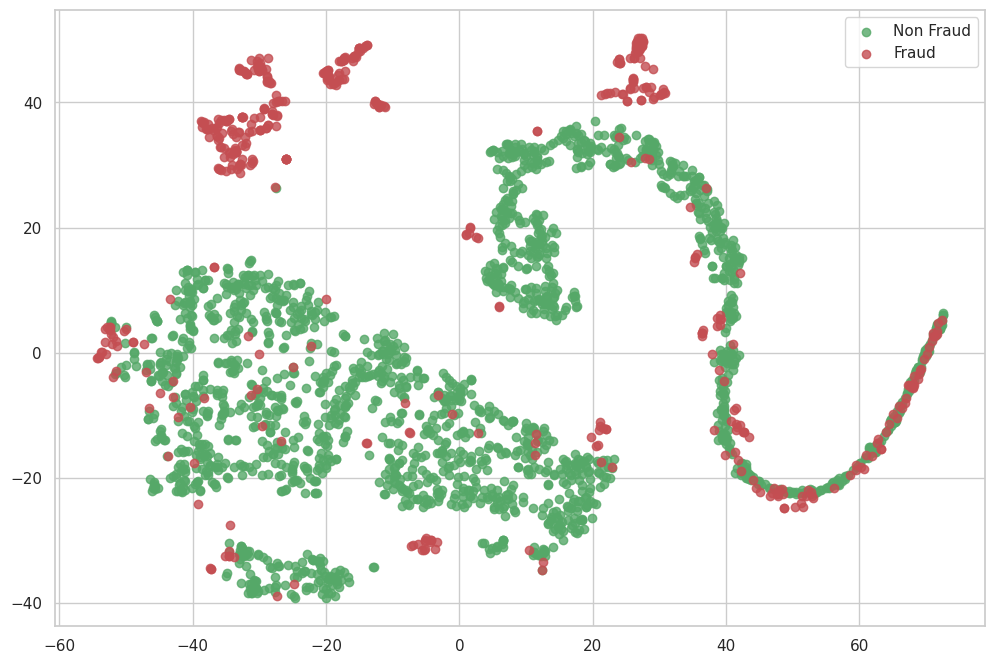

In [199]:
# Define a function for plotting 2D t-SNE visualization
def tsne_plot(x1, y1, name="graph.png"):
    # Initialize t-SNE with 2 output dimensions and a fixed random state for reproducibility
    tsne = TSNE(n_components=2, random_state=0)
    # Transform the input features to 2D using t-SNE
    X_t = tsne.fit_transform(x1)

    # Create a figure for the plot with a specified size
    plt.figure(figsize=(12, 8))
    # Scatter plot for non-fraud transactions (Class 0) in green
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
    # Scatter plot for fraudulent transactions (Class 1) in red
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')

    # Add a legend to the plot
    plt.legend(loc='best')
    # Save the plot as an image file with the specified name
    plt.savefig(name)
    # Display the plot
    plt.show()

# Call the tsne_plot function with input data X and labels Y, and save the result as "original.png"
tsne_plot(X, Y, "original.png")

**AutoEncoders**

**Layer with 100 - 70 - 50  / 50 - 70 - 100**

In [200]:
# from keras.layers import Input, Dense
# from keras.models import Model
# from keras import regularizers

# # Assuming X is input data and already defined

# ## input layer
# input_layer = Input(shape=(X.shape[1],))

# ## encoding part
# encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
# encoded = Dense(70, activation='relu')(encoded)
# encoded = Dense(50, activation='relu')(encoded)

# ## decoding part
# decoded = Dense(50, activation='relu')(encoded)
# decoded = Dense(70, activation='tanh')(encoded)
# decoded = Dense(100, activation='tanh')(decoded)

# ## output layer
# output_layer = Dense(X.shape[1], activation='relu')(decoded)

# # Create the autoencoder model
# autoencoder = Model(input_layer, output_layer)

# # Compile the model
# autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# # Summary of the model to check the architecture
# autoencoder.summary()


**Layer with 100 - 70 - 50  / 70 - 100**

In [201]:
# from keras.layers import Input, Dense
# from keras.models import Model
# from keras import regularizers

# # input layer
# input_layer = Input(shape=(X.shape[1],))

# # encoding part
# encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
# encoded = Dense(70, activation='relu')(encoded)
# encoded = Dense(50, activation='relu')(encoded)

# # decoding part
# decoded = Dense(70, activation='tanh')(encoded)
# decoded = Dense(100, activation='tanh')(decoded)

# # output layer
# output_layer = Dense(X.shape[1], activation='relu')(decoded)

# # Create the autoencoder model
# autoencoder = Model(input_layer, output_layer)

# # Compile the model
# autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# # Summary of the model to check the architecture
# autoencoder.summary()



Layer with 30 - 8 - 2  / 2 - 8 -30

In [202]:
# from keras.layers import Input, Dense
# from keras.models import Model
# from keras import regularizers

# # input layer
# input_layer = Input(shape=(X.shape[1],))

# # encoding part
# encoded = Dense(30, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
# encoded = Dense(8, activation='relu')(encoded)
# encoded = Dense(2, activation='relu')(encoded)

# # decoding part
# decoded = Dense(2, activation='relu')(encoded)
# decoded = Dense(8, activation='tanh')(encoded)
# decoded = Dense(30, activation='tanh')(decoded)

# # output layer
# output_layer = Dense(X.shape[1], activation='relu')(decoded)

# # Create the autoencoder model
# autoencoder = Model(input_layer, output_layer)

# # Compile the model
# autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# # Summary of the model to check the architecture
# autoencoder.summary()



Layer with 30 - 10  / 10 - 30

In [203]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

# input layer
input_layer = Input(shape=(X.shape[1],))

# encoding part
encoded = Dense(30, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(10, activation='relu')(encoded)

# decoding part
decoded = Dense(10, activation='tanh')(encoded)
decoded = Dense(30, activation='tanh')(decoded)

# output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

# Create the autoencoder model
autoencoder = Model(input_layer, output_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model to check the architecture
autoencoder.summary()



Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_67 (Dense)            (None, 30)                930       
                                                                 
 dense_68 (Dense)            (None, 10)                310       
                                                                 
 dense_69 (Dense)            (None, 10)                110       
                                                                 
 dense_70 (Dense)            (None, 30)                330       
                                                                 
 dense_71 (Dense)            (None, 30)                930       
                                                                 
Total params: 2610 (10.20 KB)
Trainable params: 2610 (10.2

In [204]:
# Define the autoencoder model using the Keras library
autoencoder = Model(input_layer, output_layer)
# Compile the autoencoder model with the specified optimizer and loss function
autoencoder.compile(optimizer="adadelta", loss="mse")

In [205]:
# Extract features (x) by removing the "Class" column from the dataset
x = data.drop(["Class"], axis=1)
# Extract class labels (y) from the "Class" column
y = data["Class"].values

# Scale the features using Min-Max scaler
x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
# Separate scaled data into two subsets: x_nfraud for non-fraud transactions (Class 0) and x_fraud for fraud transactions (Class 1)
x_nfraud, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [206]:
# Train the autoencoder model on a subset of non-fraud transactions
autoencoder.fit(x_nfraud[0:2000], x_nfraud[0:2000],
                batch_size = 256, epochs = 10,
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 [==============================] - 1s 35ms/step - loss: 0.2257 - val_loss: 0.2251
Epoch 2/10
7/7 [==============================] - 0s 12ms/step - loss: 0.2256 - val_loss: 0.2250
Epoch 3/10
7/7 [==============================] - 0s 8ms/step - loss: 0.2255 - val_loss: 0.2249
Epoch 4/10
7/7 [==============================] - 0s 11ms/step - loss: 0.2254 - val_loss: 0.2248
Epoch 5/10
7/7 [==============================] - 0s 8ms/step - loss: 0.2253 - val_loss: 0.2247
Epoch 6/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2252 - val_loss: 0.2247
Epoch 7/10
7/7 [==============================] - 0s 8ms/step - loss: 0.2252 - val_loss: 0.2246
Epoch 8/10
7/7 [==============================] - 0s 8ms/step - loss: 0.2251 - val_loss: 0.2245
Epoch 9/10
7/7 [==============================] - 0s 11ms/step - loss: 0.2250 - val_loss: 0.2244
Epoch 10/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2249 - val_loss: 0.2243


**Obtain the Latent Representations**

In [207]:
# # Create a new Sequential model for the hidden representation
# hidden_representation = Sequential()
# # Add the input layer of the Autoencoder model to the Sequential model
# hidden_representation.add(autoencoder.layers[0])
# # Add the first hidden layer of the Autoencoder model to the Sequential model
# hidden_representation.add(autoencoder.layers[1])
# # Add the second hidden layer of the Autoencoder model to the Sequential model
# hidden_representation.add(autoencoder.layers[2])
# # Add the output layer of the Autoencoder model to the Sequential model
# hidden_representation.add(autoencoder.layers[3])

Layer with 30 - 10 / 10 - 30

In [208]:
# Create a new Sequential model for the hidden representation
hidden_representation = Sequential()
# Add the input layer of the Autoencoder model to the Sequential model
hidden_representation.add(autoencoder.layers[0])
# Add the first hidden layer of the Autoencoder model to the Sequential model
hidden_representation.add(autoencoder.layers[1])
# Add the second hidden layer of the Autoencoder model to the Sequential model
hidden_representation.add(autoencoder.layers[2])

In [209]:
# Generate hidden representations for 3000 samples of non-fraud transactions using the hidden_representation model
norm_hid_rep = hidden_representation.predict(x_nfraud[:3000])
# Generate hidden representations for all fraud transactions using the hidden_representation model
fraud_hid_rep = hidden_representation.predict(x_fraud)

16/16 [==============================] - 0s 2ms/step


**Visualize the latent representations : Fraud Vs Non Fraud**

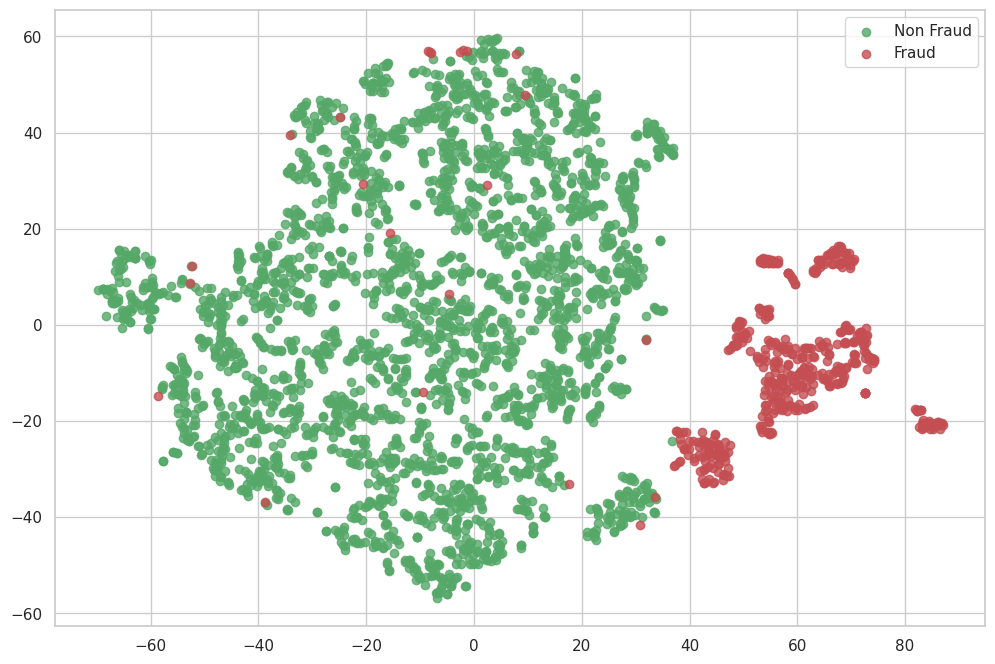

In [ ]:
# Combine the hidden representations of non-fraud and fraud transactions
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)

# Create labels for non-fraud transactions (0) and fraud transactions (1)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])

# Combine the labels for both classes
rep_y = np.append(y_n, y_f)

# Visualize the latent representations using t-SNE and save the plot as "latent_representation.png"
tsne_plot(rep_x, rep_y, "latent_representation.png")

**Simple Linear Classifier**

In [210]:
# Split the latent representations and labels into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
# Create a Logistic Regression model using the lbfgs solver and train it on the training set
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
# Predict the labels for the validation set using the trained Logistic Regression model
pred_y = clf.predict(val_x)

# Print the Classification Report showing precision, recall, and other metrics
print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

# Print the Accuracy Score of the Logistic Regression model on the validation set
print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       753
         1.0       1.00      0.79      0.88       120

    accuracy                           0.97       873
   macro avg       0.98      0.90      0.93       873
weighted avg       0.97      0.97      0.97       873


Accuracy Score:  0.9713631156930126


**Clusterring**

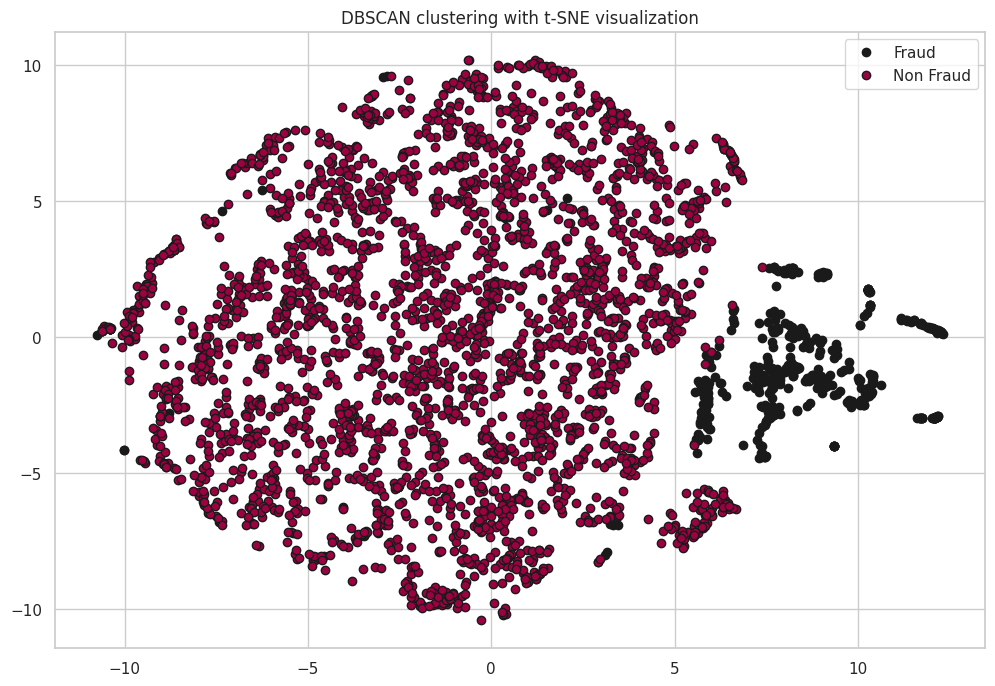


Accuracy Score:  0.9891179839633448


In [212]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

# Assuming rep_x is complete dataset
# Splitting the dataset for the purpose of demonstration, even though we'll only use rep_x for DBSCAN and t-SNE
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)

# Combining train_x and val_x for clustering (assuming rep_x is already full dataset)
X = np.vstack((train_x, val_x))
Y = np.hstack((train_y, val_y))
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.1, min_samples=300).fit(X)
labels = dbscan.labels_

# Run t-SNE to reduce dimensionality for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X)

# Plotting
plt.figure(figsize=(12, 8))
unique_labels = np.unique(labels)
for label in unique_labels:
    if label == -1:
        # Black used for noise.
        col = 'k'
    else:
        col = plt.cm.Spectral(float(label) / len(unique_labels))
    class_member_mask = (labels == label)
    xy = X_tsne[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6, label='Non Fraud' if label != -1 else 'Fraud')

plt.title('DBSCAN clustering with t-SNE visualization')
plt.legend(loc='best')
plt.show()

y_predict = labels * -1
# Print the Accuracy Score
print ("")
print ("Accuracy Score: ", accuracy_score(Y, y_predict))